In [43]:
# Parameters
artificial_humans = "../../artifacts/artificial_humans/04_3_model/model/architecture_node+edge+rnn.pt"
artificial_humans_valid = "../../artifacts/artificial_humans/02_3_valid/model/rnn_True.pt"
artificial_humans_model = "graph"
manager = "../../artifacts/manager_v3/17_model3/model/architecture_node+edge+rnn__run_0.pt"
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 10000

In [44]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory_v1 import Memory
from aimanager.manager.environment import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')


plot_folder = f'plots/simulate_ah_om'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=device)
artifical_humans_valid = GraphNetwork.load(artificial_humans_valid, device=device)

mg = ArtificalManager.load(manager, device=th.device('cpu'))


env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, artifical_humans_valid=artifical_humans_valid, 
    n_agents=4, n_contributions=21, n_punishments=31, 
    n_rounds=n_episode_steps, batch_size=n_episodes, device=device)

recorder = Memory(n_episodes=1, n_episode_steps=n_episode_steps, output_file=None, device=device)

state = env.reset()
for round_number in count():
    _state = {**state, **env.get_batch_structure()}
    encoded = mg.encode_pure(_state)

    q_values = mg.get_q(encoded, first=round_number == 0)

    action = q_values.argmax(-1)

    state = env.punish(action)

    recorder.add(**{k: v.squeeze(-1) for k, v in state.items()}, episode_step=round_number)
    state, reward, done = env.step()
    if done:
        break
# recorder.next_episode(episode)

In [46]:
columns = ['round_number','participant_code']
# columns = ['round_number']

punishments = using_multiindex(recorder.memory['punishments'][0].numpy(), columns=columns, value_name='punishment')
common_good = using_multiindex(recorder.memory['common_good'][0].numpy(), columns=columns, value_name='common_good')
contributions = using_multiindex(recorder.memory['contributions'][0].numpy(), columns=columns, value_name='contribution')
valid = using_multiindex(recorder.memory['valid'][0].numpy(), columns=columns, value_name='valid')
prev_contributions = using_multiindex(recorder.memory['prev_contributions'][0].numpy(), columns=columns, value_name='prev_contribution')

df_sim = punishments.merge(common_good).merge(contributions).merge(prev_contributions).merge(valid)
df_sim['data_source'] = 'simulation'
df_sim['trend'] = 'neutral'
df_sim.loc[(df_sim['prev_contribution'] > df_sim['contribution']), 'trend'] = 'negative'
df_sim.loc[(df_sim['prev_contribution'] < df_sim['contribution']), 'trend'] = 'positive'

data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}


df_pilot = pd.read_csv(data_file)

df_pilot['data_source'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4
df_pilot['valid'] = df_pilot['player_no_input'] == 0
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'valid', 'participant_code', 'punishment', 'data_source']]


df = pd.concat([df_sim, df_pilot]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source', 'prev_contribution', 'trend'], 
    value_vars=['punishment', 'contribution', 'common_good'])

df_sim_valid = df_sim[df_sim['valid']]

    

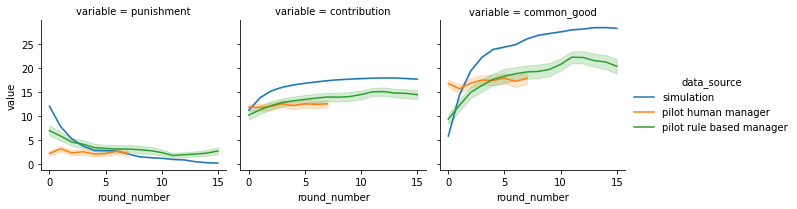

In [47]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='data_source',
    kind="line",
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))


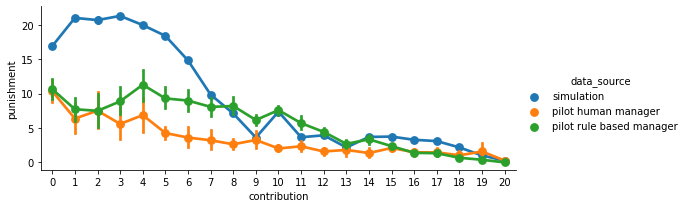

In [48]:
df['contribution'] = df['contribution'].astype(int)
w = df['valid']

g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='data_source',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

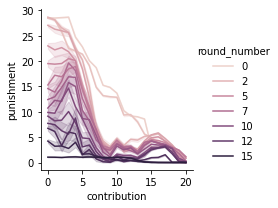

In [49]:
g = sns.relplot(
    data=df_sim_valid,
    x="contribution", 
    y="punishment",
    hue='round_number',
    kind="line",
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'policy_round_number.jpg'))


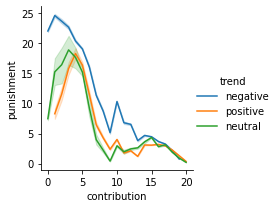

In [50]:
w = df_sim['valid']


g = sns.relplot(
    data=df_sim_valid,
    x="contribution", 
    y="punishment",
    hue='trend',
    kind="line",
    height=3, aspect=1,
)

In [68]:
df_sim_valid = df_sim_valid.copy()
df_sim_valid['mean contribution (round 1-8)'] = ((
    df_sim_valid.groupby(['participant_code'])['contribution'].cumsum() - df_sim_valid['contribution'])
    / df_sim_valid.groupby(['participant_code'])['contribution'].cumcount())

In [69]:
dfs = df_sim_valid.replace([np.inf, -np.inf], np.nan)
dfs = dfs[~dfs['mean contribution (round 1-8)'].isnull()]
dfs['mean contribution (round 1-8)'] = pd.cut(dfs['mean contribution (round 1-8)'], 4)

In [70]:
dfs = dfs[(dfs['round_number'] > 8)]

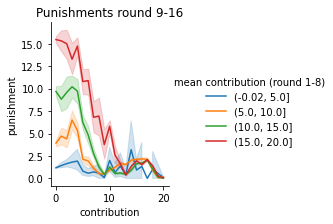

In [71]:
g = sns.relplot(
    data=dfs,
    x="contribution", 
    y="punishment",
    hue='mean contribution (round 1-8)',
    kind="line",
    height=3, aspect=1,
)

g.set(title='Punishments round 9-16')

g.savefig(os.path.join(plot_folder, 'policy_prev_contribution.jpg'))